**분석개요**

    A. 가볼래터 성과 분석 리포트
        1. 매체별 유입 분석
            1) 유입
            2) 재방문
            3) 구독 전환
            4) 이상 유저
            5) 앱설치
            6) 활성
            7) 리텐션
        2. 이동 경로 분석

In [1]:
# basic
import gc
import os
import sys
import warnings
warnings.filterwarnings(action='ignore') 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#--------------------#
# handling
#--------------------#
import math
import time
import random
# import openpyxl
import importlib
import xlsxwriter
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime, timedelta

#--------------------#
# Vis
#--------------------#
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
## Vis for jupyter theme
from IPython.display import Image
from jupyterthemes import jtplot
jtplot.style(theme= 'grade3', context='notebook', ticks=True, grid=False) ## dark backgroud jupyter notebook theme
# plt.style.use(['seaborn-white']) ## dark background style ## white style : 'seaborn-white'
plt.style.use(['dark_background']) ## dark background style ## white style : 'seaborn-white'
## Vis for korean 
import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf'
fprop = fm.FontProperties(fname=font_location)
font_name = fprop.get_name()
matplotlib.rc('font', family=font_name)

In [2]:
#--------------------#
# sphere package
#--------------------#
sys.path.append("/home/das_share/sphere_class/")
import SpherePackage
from SpherePackage import *
for pkg in [SpherePackage] :
    _ = importlib.reload(pkg)

#--------------------#
# kto package
#--------------------#
sys.path.append("../src/")
import kto_config
import kto_util
import kto_prep
from kto_config import *
from kto_prep import *
from kto_util import *

for pkg in [kto_config, kto_prep, kto_util] :
    _ = importlib.reload(pkg)

# 1.Data Import

In [3]:
#------------------------------------------------#
# 1. log Data import
#------------------------------------------------#
# dates: 10월 한 달
df_app_log = DataImport.read_files(
    input_path = INPUT_PATH + DATA_TYPE + APP_KEY, 
    today = today + timedelta(days = 1), 
    dates = dates,
    platform_total = True, reduce_memory = True, verbose = False)

In [4]:
df_app_log_copy = df_app_log.copy()

# 2.Preprocess

In [5]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 1) log
df_app_log = SpherePrep.BasicPrep.basic_prep(df_app_log)                # log data

## 2) user prop
df_prop = SpherePrep.Prop.df_prop_pipe(df_app_log, KEY_ID = [KEY_ID_DEVICE, KEY_ID_USER])       # user data
df_prop_manual = KtoPrep.import_prop_manul_data() 
df_prop = pd.merge(
    left = df_prop, right = df_prop_manual[[KEY_ID_USER, 'birth_y' #'gender'
    ]],
    on = KEY_ID_USER, how = 'left')

In [6]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 3) param - 1
_, df_param_all = DataImport.json_to_dataframe_nodeN(
    df_app_log, [KEY_ID_DEVICE, KEY_ID_USER]
    )

In [7]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 3) param - 2
_, df_param_all_session = DataImport.json_to_dataframe_nodeN( 
    df_app_log, [KEY_ID_DEVICE, KEY_ID_USER, 'sid']
    ) ### + param by session

In [8]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 4) referr
lst_extrated_referr_cols = ['utm_campaign', 'utm_source', 'utm_medium']
df_app_log = SpherePrep.Attribution_Prep.gen_session_referr_cols(
        df_app_log, 
        referr_col = 'referrer', 
        lst_extrated_referr_cols = lst_extrated_referr_cols,
        fill_na_organic = True)

In [9]:
#------------------------------------------------#
# 2. param detail data
#------------------------------------------------#
## 1) event 기준
# df_param_install = DataImport.extract_event_param(df_param_all, EVENT_APP_INSTALL).drop_duplicates()
df_param_contents = DataImport.extract_event_param(df_param_all, EVENT_CONTENT_DETAIL).drop_duplicates()
df_param_subscribe = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE).drop_duplicates()
df_param_letter_main = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE_LETTER).drop_duplicates()
df_param_like = DataImport.extract_event_param(df_param_all, EVENT_SUBSCRIBE_LIKE).drop_duplicates()
df_param_signup = DataImport.extract_event_param(df_param_all, EVENT_SIGNUP).drop_duplicates()

## 2) 가볼래터 data 생성
df_param_contents_letter = df_param_all_session[df_param_all_session[PARAM_CONTENT_NAME].str.contains('가볼래-터', na=False)]

In [63]:
df_param_contents_letter[PARAM_CONTENT_NAME].unique()

array(['가볼래-터 구독하러 가기', "여행구독 '가볼래-터' 구독자 레벨업을 위한 ★미션 참여 방법& 선물 언박싱★",
       '매월 당신의 눈앞에 여행을 배송!가볼래-터 구독하러가기!',
       '매월 당신의 눈앞에 여행을 배송!여행구독 <가볼래-터> 구독하러가기!',
       '가볼래-터 9월호 OPEN! 인천 여행 특집 🚩',
       '핫플레이스와 신상 여행정보가 가득 담긴＇가볼래-터＇구독 신청하고 매월 초간단 미션을 완료하면 특별한 선물이 담긴 여행복권을 드립니다!',
       '＇가볼래-터＇구독 신청하고 미션 선물받자!',
       '[2차 앵콜] 다시 돌아온 가볼래-터 깜짝 이벤트! 여행구독 미션 참여하고, 카톡 이모티콘 받자!',
       '대한민국 구석구석 여행구독 서비스! 가볼래-터 구독자 대상 만족도 조사',
       '대한민국 구석구석 여행구독 서비스! 가볼래-터 구독자 대상 만족도 조사 당첨자 발표',
       '매월 당신의 눈앞에 여행을 배송!매월 당신의 눈앞에 여행을 배송!여행구독 <가볼래-터> 구독하러가기!여행구독 <가볼래-터> 구독하러가기!',
       '여행구독 서비스! 가볼래-터 10월호 Open!', '여행을 구독하세요!가볼래-터 10월호 Open!',
       '여행을 구독하세요!✨가볼래-터 10월호 Open✨'], dtype=object)

## 1)Utils

In [10]:
## 원래 함수
def cnt_to_percent_ver1(df, col):
    df[col] = df[col].astype(float)

    if  df.index.dtype != 'str':
        df.index = df.index.astype('str')
    
    _lst = []
    for i in range(0,len(df)):
        x = round((df[col][i] / df[col].sum())*100, 2)
        _lst.append(x)

    df['percent']= _lst
    return df


def cal_event_cnt_per_device_ver1(df_target, dict_referrs, lst_event, text):
    dict_page_cnt = {}
    for key, values in dict_referrs.items():
        _df = df_target[df_target[KEY_ID_DEVICE].isin(values)]
        _series_event_cnt = _df['abs_events'].apply(lambda x : len(set(x) & set(lst_event))
                                if len(set(lst_event) & set(x)) > 0 else 0)
        _df['page_cnt'] = _series_event_cnt
        EVENT_CNT_PER_DEVICE = _df.groupby([KEY_ID_DEVICE, 'day'])['page_cnt'].count().mean()
        
        dict_page_cnt[f'{key}'] = _series_event_cnt
        print(f'{key}', text, round(EVENT_CNT_PER_DEVICE, 2), '회')


def cal_event_cnt_per_device_ver2(df_target, text):
        df_target['event_cnt'] = df_target['abs_events'].apply(lambda x: len(x))
        EVENT_CNT_PER_DEVICE = df_target.groupby([KEY_ID_DEVICE, 'day'])['event_cnt'].count().mean()
        print(text, round(EVENT_CNT_PER_DEVICE, 2), '회')

# 3.Analysis
## 0)Segment Setting

In [12]:
#------------------------------------------------#
# 1. segment by referrer
#------------------------------------------------#
dict_lst_user_from_referrs = KtoPrep.get_user_list_by_referr(
    df_app_log, KEY_ID = KEY_ID_DEVICE,
    DEPTH_1_COL = 'referrer_utm_campaign', 
    DEPTH_2_COL = 'referrer_utm_source') 
dict_lst_user_from_referrs_gudok = dict_lst_user_from_referrs['2022_gudok']
dict_lst_user_from_referrs_gudok['organic']  = dict_lst_user_from_referrs['organic']['organic'] # organic 유입 추가

#------------------------------------------------#
# 2. segment by duration per device
#------------------------------------------------#
df_duration_per_device = df_app_log.groupby([KEY_ID_DEVICE])['duration'].sum()
dict_duration_seg = dict()
dict_duration_seg['high'] = df_duration_per_device[
    df_duration_per_device >= df_duration_per_device.quantile(0.66)].index
dict_duration_seg['middle'] = df_duration_per_device[
    (df_duration_per_device < df_duration_per_device.quantile(0.66)) &
    (df_duration_per_device >= df_duration_per_device.quantile(0.33))
    ].index
dict_duration_seg['low'] = df_duration_per_device[
    df_duration_per_device < df_duration_per_device.quantile(0.33)].index

#------------------------------------------------#
# 3. segment by new or re
#------------------------------------------------#
lst_new_device = list(df_app_log[df_app_log['created_date'] >= datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())
lst_re_device = list(df_app_log[df_app_log['created_date'] < datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())

#------------------------------------------------#
# 4. segment by fraud or total
#------------------------------------------------#
lst_fraud_device = list(df_app_log[df_app_log['duration'] <  5][KEY_ID_DEVICE].unique())
lst_total_device = list(df_app_log[KEY_ID_DEVICE].unique())

#------------------------------------------------#
# 5. segment by demo (gender or age)
#------------------------------------------------#
## gender
dict_seg_gender = dict()
dict_seg_gender['m'] = list(df_prop[df_prop['gender'] == 'm'][KEY_ID_DEVICE])
dict_seg_gender['f'] = list(df_prop[df_prop['gender'] == 'f'][KEY_ID_DEVICE])

## age
dict_seg_age = dict()
dict_seg_age['20_30'] = list(df_prop[(datetime.today().year - df_prop['birth_y']) < 40][KEY_ID_DEVICE])
dict_seg_age['40_50'] = list(df_prop[(datetime.today().year - df_prop['birth_y']) >= 40][KEY_ID_DEVICE])
# # ======================================================== #  next version
# dict_seg_age['20_30'] = list(df_prop[df_prop['age'] < 40][KEY_ID_DEVICE])
# dict_seg_age['40_50'] = list(df_prop[df_prop['age'] >= 40][KEY_ID_DEVICE])

#------------------------------------------------#
# 6. subscribe segment 
#------------------------------------------------#
lst_subscribe_device = list(df_app_log[
    df_app_log['abs_events'].apply(lambda x : True if EVENT_SUBSCRIBE in x else False)
    ][KEY_ID_DEVICE].values)

In [13]:
## prep: instagram, kakao_mo -> drop
del dict_lst_user_from_referrs_gudok['instagram']
del dict_lst_user_from_referrs_gudok['kakao_mo']
dict_lst_user_from_referrs_gudok.keys()

dict_keys(['kakaotalk_bizmessage', 'GDN', 'KAKAO_moment', 'FB_INSTA', 'NAVER_GFA', 'organic'])

## 1)매체 성과 분석
### (1)유입
- 전체 유입
- 신규/기존 유입

In [16]:
#########################################
# 1. 매체별 전체 유입인원
#########################################
dict_output_inflow_cnt = {}

for key, values in dict_lst_user_from_referrs_gudok.items():
    dict_output_inflow_cnt[f'{key}'] = {}
    dict_output_inflow_cnt[f'{key}']['inflow_cnt'] = len(values)

df_vis1 = pd.DataFrame.from_dict(dict_output_inflow_cnt, orient='index', columns=['inflow_cnt'])
df_vis1.sort_values(by = 'inflow_cnt', ascending=False)

# SphereVis.basic_bar_plot(
#     df_vis1, x = df_vis1.index, y = 'percent', title= '가볼래-터 매체별 전체 유입인원')
# plt.show()

,inflow_cnt
organic,1711477
NAVER_GFA,6900
GDN,6831
FB_INSTA,5657
kakaotalk_bizmessage,5366
KAKAO_moment,4165


In [17]:
#########################################
# 2. 신규/기존 유입
#########################################
## 1) 일별 전체 신규 유입
def get_daily_cnt(
                  dict_output, lst, nm, df_target = df_app_log, KEY_ID = KEY_ID_DEVICE, 
                  dict_input = dict_lst_user_from_referrs_gudok, make_sub_dict = False):
    # 1. 전체 일별 수치
    df_daily = df_app_log[df_app_log[KEY_ID].isin(lst)].groupby('day')[KEY_ID]\
                    .nunique().to_frame(name = f'total_{nm}')

    # 2. 매체별 일별 수지
    for key, values in dict_input.items():
        _lst_id = list(set(lst) &  set(values))
        _df = df_app_log[df_app_log[KEY_ID].isin(_lst_id)].groupby('day')[KEY_ID]\
                    .nunique().to_frame(name = f'{key}_{nm}').fillna(0)
        if make_sub_dict == True:
            dict_output[f'{key}'] = {}

        dict_output[f'{key}'][f'{nm}'] = _df
        # dict_output[f'{key}_{nm}'] 
        df_daily[f'{key}'] = _df[f'{key}_{nm}']
        df_daily.fillna(0, inplace=True)
        # pd.concat([df_daily, dict_output[f'{key}'][f'{key}_{nm}']], axis=1).fillna(0)
        
    return df_daily
    

df_daily_new_inflow = get_daily_cnt(dict_output_inflow_cnt, lst=lst_new_device, nm='new_inflow')
df_daily_new_inflow

## 3) 일별 전체 기존 유입
df_daily_re_inflow = get_daily_cnt(dict_output_inflow_cnt, lst=lst_re_device, nm='re_inflow')
df_daily_re_inflow

,total_new_inflow,kakaotalk_bizmessage,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,organic
day,,,,,,,
2022-10-01,93386,16,1.0,0.0,1.0,5.0,93138
2022-10-02,84310,8,1.0,1.0,0.0,2.0,84108
2022-10-03,61376,5,0.0,1.0,1.0,3.0,61195
2022-10-04,57880,9,1.0,0.0,2.0,4.0,57645
2022-10-05,55969,35,0.0,0.0,3.0,0.0,55618
2022-10-06,46015,10,0.0,1.0,0.0,5.0,45741
2022-10-07,69333,10,3.0,0.0,0.0,2.0,68931
2022-10-08,115547,11,2.0,1.0,0.0,9.0,115192
2022-10-09,61837,8,2.0,0.0,0.0,5.0,61554


,total_re_inflow,kakaotalk_bizmessage,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,organic
day,,,,,,,
2022-10-01,24470,47,1.0,0.0,1.0,3,24253
2022-10-02,20068,35,2.0,0.0,2.0,5,19877
2022-10-03,13907,25,6.0,0.0,1.0,3,13689
2022-10-04,13604,39,3.0,1.0,1.0,2,13389
2022-10-05,13117,142,1.0,0.0,4.0,2,12843
2022-10-06,13224,41,2.0,1.0,0.0,5,13031
2022-10-07,16509,43,2.0,3.0,2.0,7,16206
2022-10-08,20795,20,3.0,1.0,1.0,3,20601
2022-10-09,14770,13,4.0,0.0,3.0,5,14604


### (2)재방문
- 방문 빈도별 재방문율
- 주차별 재방문율

In [18]:
#########################################
# 1. 방문 빈도별 재방문율
#########################################
## data setting by referrs
dict_visit_cnt = {}
dict_df_param_contents = {}

for key, values in dict_lst_user_from_referrs_gudok.items():
    dict_df_param_contents[key] = df_param_contents_letter[
                                        df_param_contents_letter[KEY_ID_DEVICE].isin(
                                            dict_lst_user_from_referrs_gudok[key])]
                                            
    _df = dict_df_param_contents[key].groupby(KEY_ID_DEVICE)['day'].size().to_frame(
        name = 'day_cnt')
        
    VISIT_1_CNT = len(_df[_df['day_cnt'] == 1])
    VISIT_2_CNT = len(_df[_df['day_cnt'] == 2])
    VISIT_3_CNT = len(_df[_df['day_cnt'] >= 3])

    VISIT_1_RATE = VISIT_1_CNT / len(_df)
    REVISIT_2_RATE= 1 - VISIT_1_RATE
    REVISIT_3_RATE = 1 - ((VISIT_1_CNT + VISIT_2_CNT) / len(_df))

    # dict_visit_cnt[f'{key}'] = {}
    dict_visit_cnt[f'{key}']= [VISIT_1_RATE, REVISIT_2_RATE, REVISIT_3_RATE]

df_vis_revisit = pd.DataFrame.from_dict(
    dict_visit_cnt, orient='index', columns=[
        'only_1_visit', 'revisit_rate', 'revisit_over_3_rate'])

df_vis_revisit

,only_1_visit,revisit_rate,revisit_over_3_rate
kakaotalk_bizmessage,0.366053,0.633947,0.416155
GDN,0.807059,0.192941,0.077059
KAKAO_moment,0.935399,0.064601,0.013449
FB_INSTA,0.840877,0.159123,0.060997
NAVER_GFA,0.867681,0.132319,0.056957
organic,0.661420,0.338580,0.201166


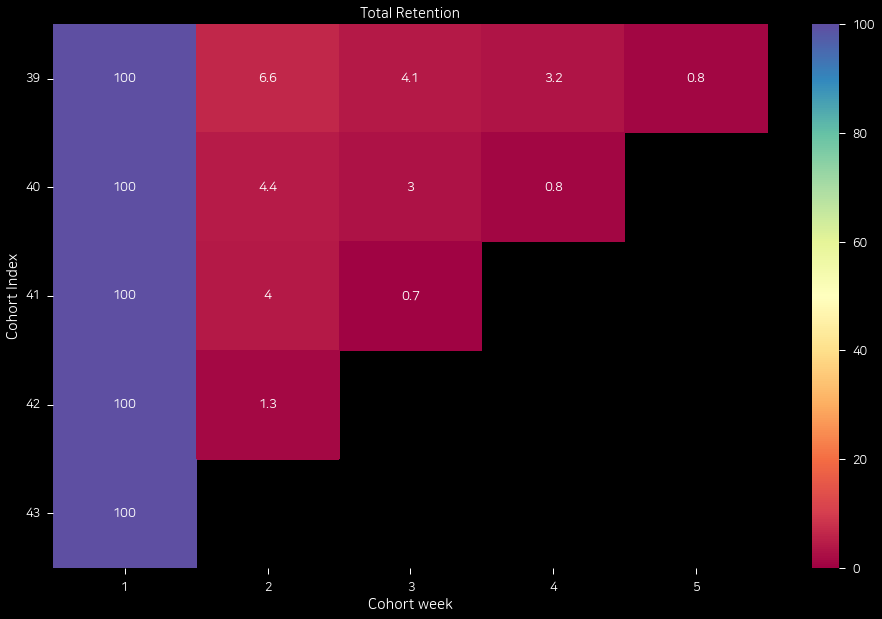

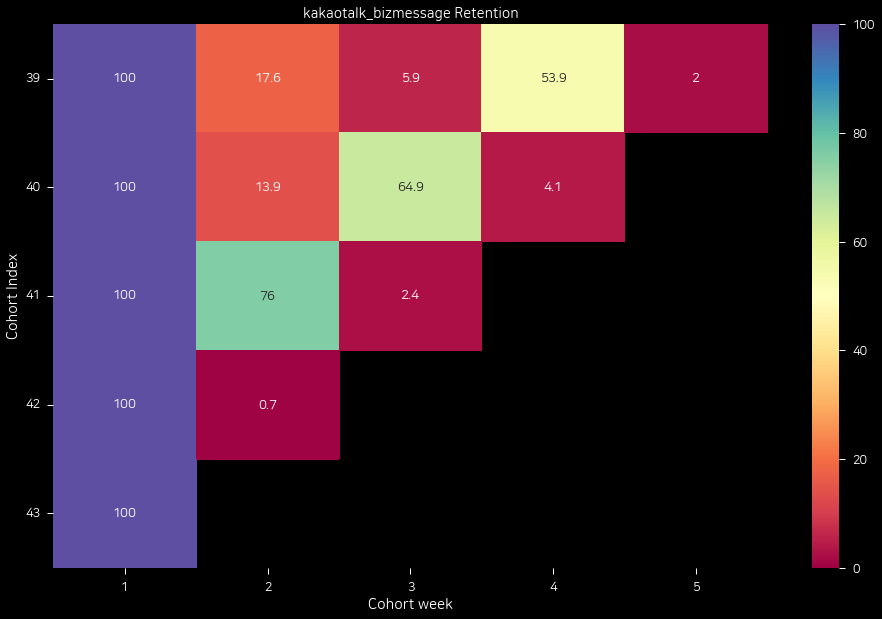

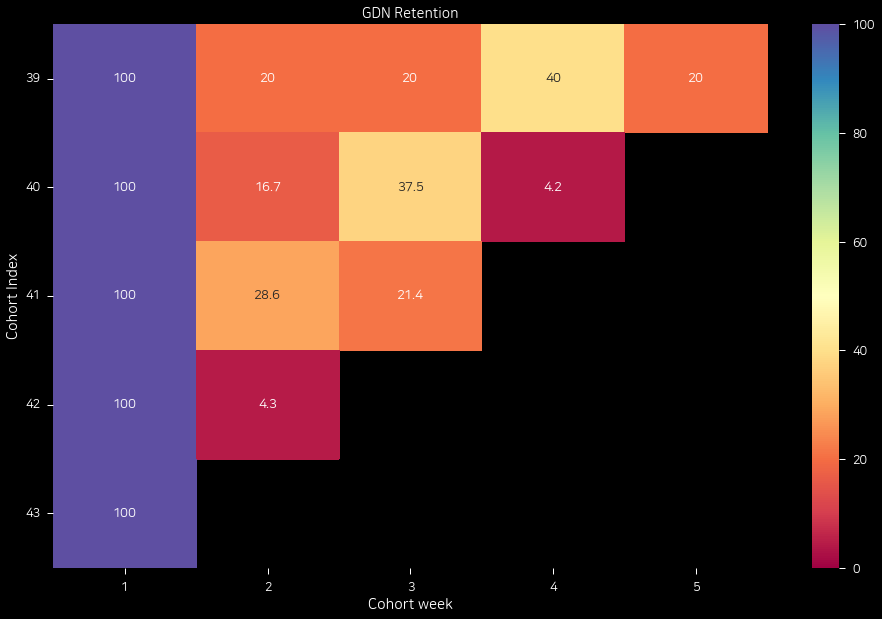

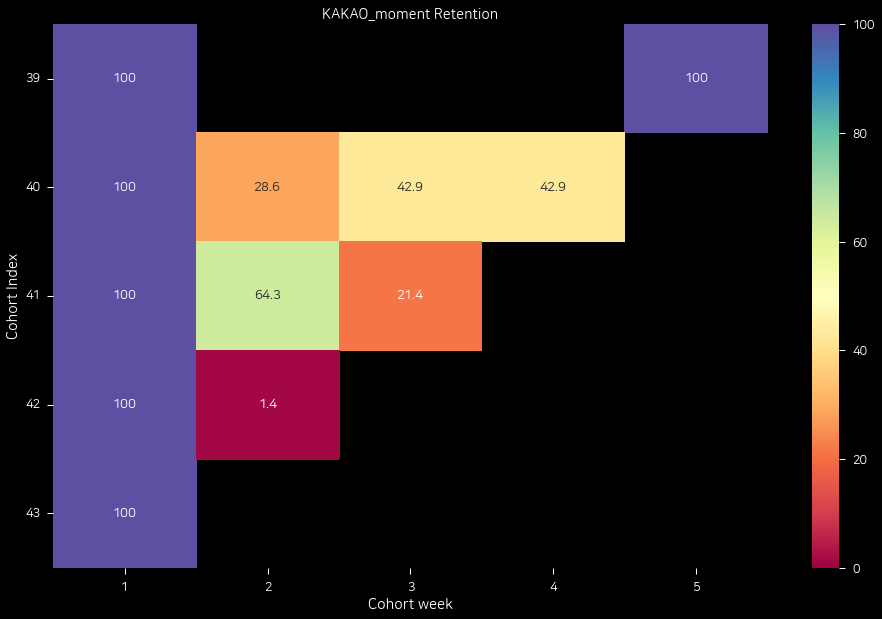

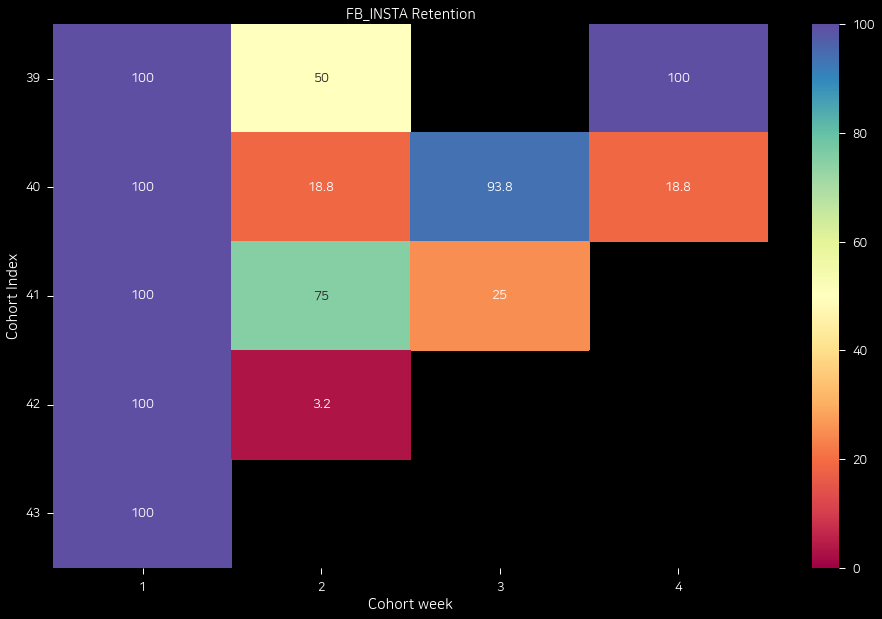

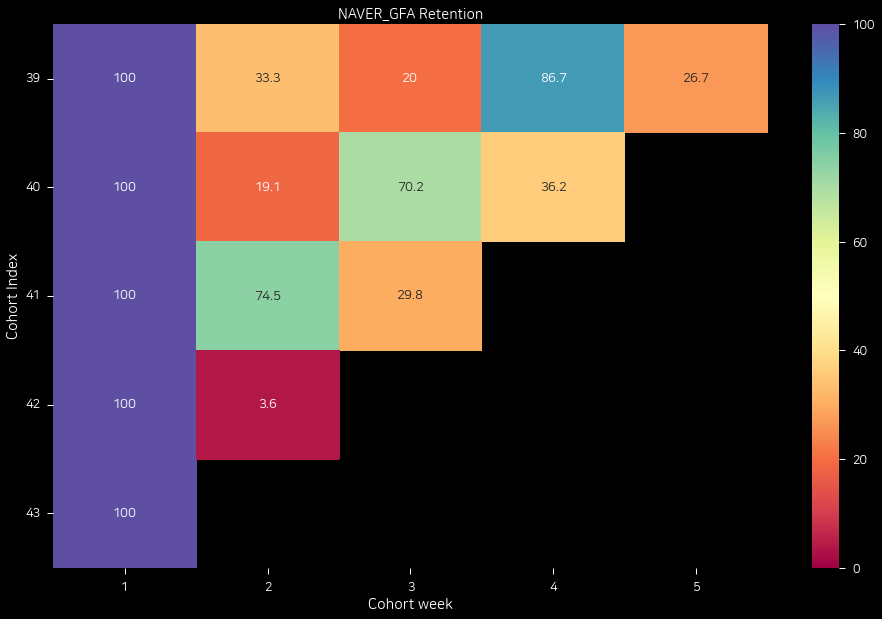

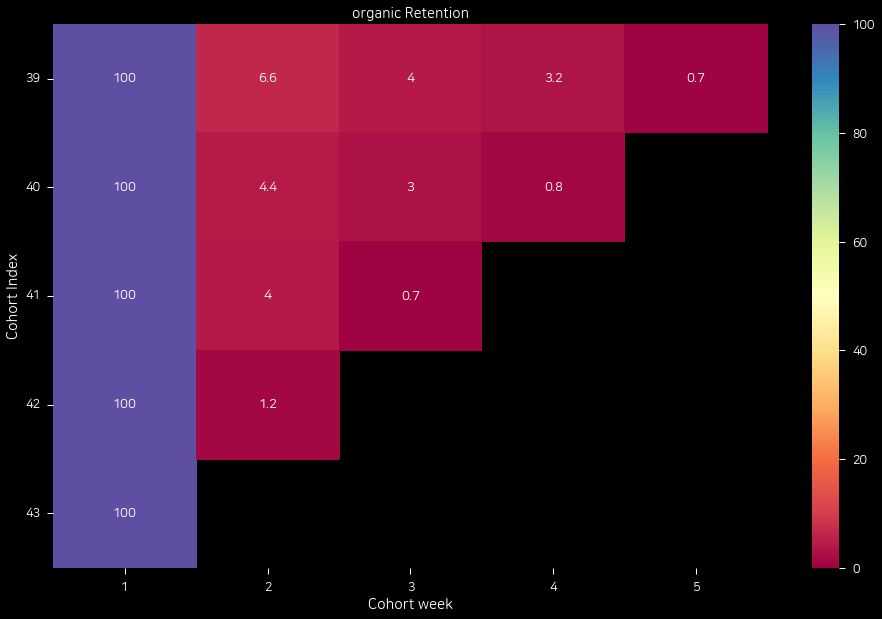

In [19]:
#########################################
# 2. 주차별 재방문율
#########################################
## 1) 전체 주차별 재방문율
df_retention = SphereRetention.retention_main(
    df_app_log, KEY_ID = KEY_ID_DEVICE, period = 'week', vis = True, title = 'Total Retention')

## 2) 매체별 주차별 재방문율
for key, values in dict_lst_user_from_referrs_gudok.items():
    df_retention = SphereRetention.retention_main(
        df_app_log[df_app_log[KEY_ID_DEVICE].isin(values)], 
        KEY_ID = KEY_ID_DEVICE, period = 'week', vis = True, title = f'{key} Retention')

### (3)구독전환
- 구독전환수
- 구독전환율

In [20]:
#########################################
# 1. 구독완료
#########################################
## 1) 일별 구독완료 유저 수
dict_subscribe = {}

df_daily_subscribe = pd.DataFrame()
df_daily_subscribe = get_daily_cnt(dict_output=dict_subscribe, lst=lst_total_device, nm='subscribe_cnt', 
                    make_sub_dict = True)
df_daily_subscribe

,total_subscribe_cnt,kakaotalk_bizmessage,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,organic
day,,,,,,,
2022-10-01,117856,63,2,0.0,2.0,8,117391
2022-10-02,104378,43,3,1.0,2.0,7,103985
2022-10-03,75283,30,6,1.0,2.0,6,74884
2022-10-04,71484,48,4,1.0,3.0,6,71034
2022-10-05,69086,177,1,0.0,7.0,2,68461
2022-10-06,59239,51,2,2.0,0.0,10,58772
2022-10-07,85842,53,5,3.0,2.0,9,85137
2022-10-08,136342,31,5,2.0,1.0,12,135793
2022-10-09,76607,21,6,0.0,3.0,10,76158


In [21]:
#########################################
# 2. 구독전환율
#########################################
## 매체별 전환율
### 랜딩페이지 > 구독
df_subscribe_conversion = pd.DataFrame(
                            index=[
                                'landing_cnt', 
                                'subscribe_cnt', 
                                'subscribe_conversion'])

for key, df in dict_df_param_contents.items():
    _df = df[df[PARAM_CONTENT_NAME] == '가볼래-터 구독하러 가기']
    LANDING_CNT = _df[KEY_ID_DEVICE].nunique()

    _df = df_param_subscribe[
                        df_param_subscribe[KEY_ID_DEVICE].isin(
                            list(_df[KEY_ID_DEVICE])
                        )]
    SUBSCRIBE_CNT = _df[KEY_ID_DEVICE].nunique()
    dict_subscribe[f'{key}']['subscribe_conversion'] = [LANDING_CNT,
                                                    SUBSCRIBE_CNT, 
                                                    (SUBSCRIBE_CNT/LANDING_CNT)]

    df_subscribe_conversion[f'{key}'] =\
        dict_subscribe[f'{key}']['subscribe_conversion']

df_subscribe_conversion

,kakaotalk_bizmessage,GDN,KAKAO_moment,FB_INSTA,NAVER_GFA,organic
landing_cnt,1668.000000,6798.000000,4164.00000,5656.000000,6899.000000,24795.000000
subscribe_cnt,51.000000,6.000000,2.00000,76.000000,30.000000,1650.000000
subscribe_conversion,0.030576,0.000883,0.00048,0.013437,0.004348,0.066546


### (4)Fraud
- 바운스율
- 정착율

In [14]:
#########################################
# 1. 바운스 유저 비율 & 정착 유저 비율
#########################################
dict_fraud_referrs = {}
for key, values in dict_lst_user_from_referrs_gudok.items():
    _df = df_app_log[df_app_log[KEY_ID_DEVICE].isin(values)]
    _df = _df.groupby(KEY_ID_DEVICE)['duration'].sum().reset_index()
    lst_device_fraud = list(_df[KEY_ID_DEVICE][_df['duration'] < 5].unique())

    TOTAL_CNT = _df[KEY_ID_DEVICE].nunique()
    FRAUD_CNT = len(lst_device_fraud)
    FRAUD_RATE = FRAUD_CNT / TOTAL_CNT
    # SETTLE_RATE = 1 - FRAUD_RATE

    dict_fraud_referrs[f'{key}'] = [TOTAL_CNT, FRAUD_CNT, FRAUD_RATE,  1 - FRAUD_RATE]

df_fraud_referrs = pd.DataFrame.from_dict(
    dict_fraud_referrs, orient='index', columns=[
        'total_cnt', 'fraud_cnt', 'fraud_rate', 'settle_rate'])

df_fraud_referrs

,total_cnt,fraud_cnt,fraud_rate,settle_rate
kakaotalk_bizmessage,5366,684,0.127469,0.872531
GDN,6831,5577,0.816425,0.183575
KAKAO_moment,4165,3921,0.941417,0.058583
FB_INSTA,5657,4821,0.852218,0.147782
NAVER_GFA,6900,6130,0.888406,0.111594
organic,1712220,1235764,0.721732,0.278268


### (5)앱설치 유저

In [23]:
#########################################
# 0. prep
#########################################
df_id_prep = SpherePrep.Prop.df_prop_pipe(
                df_app_log, [KEY_ID_DEVICE, KEY_ID_USER], 
                drop_none_prop = True)

#########################################
# 1. 앱설치 유저
#########################################
dict_install = {}
df_install_cnt = pd.DataFrame()
_df_log_target = df_app_log[df_app_log['abs_events'].apply(lambda x : True if EVENT_APP_INSTALL in x else False)]

for key, lst in dict_lst_user_from_referrs_gudok.items():
    _lst = list(set(df_id_prep[KEY_ID_DEVICE][df_id_prep[KEY_ID_DEVICE].isin(lst)]))

    dict_install[f'{key}'] = {}
    dict_install[f'{key}']['device_id'] =\
        _df_log_target[KEY_ID_DEVICE][_df_log_target[KEY_ID_DEVICE].isin(_lst)]

    dict_install[f'{key}']['cnt'] = len(dict_install[f'{key}']['device_id'])
    df_install_cnt[f'{key}_cnt'] = dict_install[f'{key}']['cnt']

    print(f'{key}: ', dict_install[f'{key}']['cnt'])

kakaotalk_bizmessage:  0
GDN:  0
KAKAO_moment:  0
FB_INSTA:  0
NAVER_GFA:  0
organic:  4571


In [24]:
# # 2. gender & age_group 
# ## KAKAO_moment: drop (설치자 0명이라서)
# dict_lst_user_from_referrs_gudok_demo = dict_lst_user_from_referrs_gudok
# del dict_lst_user_from_referrs_gudok_demo['KAKAO_moment']

# ## 시각화
# Profiling.demo_profiling(
#     df_user_prop=df_prop, KEY_ID=KEY_ID_DEVICE, 
#     dict_user_list=dict_lst_user_from_referrs_gudok_demo, 
#     total_avg = True, vis_type = 'all')

In [25]:
# ## exact numbers age/gender by referrs
# _df_gender = pd.DataFrame()
# _df_age = pd.DataFrame()

# for key, lst_id in dict_lst_user_from_referrs_gudok_demo.items():
#     if key != 'total':
#         _df = df_prop[df_prop[KEY_ID_DEVICE].isin(lst_id)]
#         _df_gender = pd.concat(
#             [_df_gender, _df['gender'].value_counts().to_frame(name = f'{key}_gender')], axis=1).fillna(0)
#         _df_age = pd.concat(
#             [_df_age, _df['age_group'].value_counts().to_frame(name = f'{key}_age')], axis=1).fillna(0)
#     else:
#         pass

# _df_gender
# _df_age

### (6)활성
- 인당 체류 시간
- 인당 컨텐츠 조회수
- 검색 조회 빈도

In [15]:
#########################################
# 1. 인당 체류시간
#########################################
lst_device_no_fraud = list(set(lst_total_device) - set(lst_device_fraud))
_df_log_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_device_no_fraud)]

dict_duration = {}
for key, values in dict_lst_user_from_referrs_gudok.items():
    _df = _df_log_target[_df_log_target[KEY_ID_DEVICE].isin(values)]

    dict_duration[f'{key}'] = {}
    dict_duration[f'{key}']['duration'] = _df.groupby(
                        KEY_ID_DEVICE)['duration'].sum().to_frame(
                            name = 'total_duration')

    print(f'{key} 인당 평균 체류시간: ', dict_duration[f'{key}']['duration']['total_duration'].mean(), '초')

kakaotalk_bizmessage 인당 평균 체류시간:  229.2433482642777 초
GDN 인당 평균 체류시간:  72.16716854755971 초
KAKAO_moment 인당 평균 체류시간:  20.177586904188733 초
FB_INSTA 인당 평균 체류시간:  19.380674769339958 초
NAVER_GFA 인당 평균 체류시간:  34.88612931538911 초
organic 인당 평균 체류시간:  273.0314843385328 초


In [16]:
#########################################
# 2. 인당 컨텐츠 조회수
#########################################
## 1) 가볼래-터 관련 컨텐츠 한정 인당 일별 조회 수
### (1) 이상 유저 제거 x

#### 이벤트 및 랜딩 페이지 접속 유저 id 리스트 생성
lst_landing_device = df_param_contents[KEY_ID_DEVICE][
    df_param_contents[PARAM_CONTENT_NAME]=='가볼래-터 구독하러 가기']

lst_event_letter = ['balanceGameMain', 'balanceGame', 'travelLetterDetail', 'travelLetterLike', 'travelLetterNotLike']

#### prep
_df_log_target_letter = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_landing_device)]

_df_log_target = _df_log_target_letter[
    _df_log_target_letter['abs_events'].apply(lambda x : True
                                    if len(set(lst_event_letter) & set(x)) > 0 else False)]

#### calculate event cnt
print('인당 가볼래-터 관련 컨텐츠 조회수(이상 유저 포함)')
cal_event_cnt_per_device_ver1(
        _df_log_target, dict_lst_user_from_referrs_gudok, 
        lst_event_letter, '인당 일별 평균 컨텐츠 조회수: ')

print('-'*50)
print('인당 가볼래-터 관련 컨텐츠 조회수(이상 유저 제거)')

### (2) 이상 유저 제거 o
#### prep
_df_log_target_no_fraud = _df_log_target_letter[_df_log_target_letter[KEY_ID_DEVICE].isin(lst_device_no_fraud)]

_df_log_target = _df_log_target_no_fraud[
    _df_log_target_no_fraud['abs_events'].apply(lambda x : True
                                    if len(set(lst_event_letter) & set(x)) > 0 else False)]

#### calculate event cnt
cal_event_cnt_per_device_ver1(
        _df_log_target_no_fraud, dict_lst_user_from_referrs_gudok, 
        lst_event_letter,'인당 일별 평균 컨텐츠 조회수: ')


#############################################################################################################


## 2) 전체 컨텐츠 인당 일별 조회 수
### 2-1) 랜딩 페이지 접속 유저

#### 이상 유저 제거 x
print('-'*50)
print('인당 전체 컨텐츠 조회수')
cal_event_cnt_per_device_ver2(_df_log_target_letter,
        '랜딩 페이지 접속 유저 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 포함): ')


#### 이상 유저 제거 o
cal_event_cnt_per_device_ver2(_df_log_target_no_fraud,
        '랜딩 페이지 접속 유저 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 제거): ')


### 2-2) 랜딩 페이지 접속 x 유저
#### 이상 유저 제거 x
lst_not_landing_device = set(lst_total_device) - set(lst_landing_device)
_df_log_target2 = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_not_landing_device)]
cal_event_cnt_per_device_ver2(_df_log_target2,
        '랜딩 페이지 접속 x 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 포함): ')


#### 이상 유저 제거 o
_df_log_target_no_fraud2 =\
        _df_log_target2[_df_log_target2[KEY_ID_DEVICE].isin(lst_device_no_fraud)]
cal_event_cnt_per_device_ver2(_df_log_target_no_fraud2,
        '랜딩 페이지 접속 x 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 제거): ')

인당 가볼래-터 관련 컨텐츠 조회수(이상 유저 포함)
kakaotalk_bizmessage 인당 일별 평균 컨텐츠 조회수:  1.78 회
GDN 인당 일별 평균 컨텐츠 조회수:  1.0 회
KAKAO_moment 인당 일별 평균 컨텐츠 조회수:  2.0 회
FB_INSTA 인당 일별 평균 컨텐츠 조회수:  1.06 회
NAVER_GFA 인당 일별 평균 컨텐츠 조회수:  1.11 회
organic 인당 일별 평균 컨텐츠 조회수:  1.6 회
--------------------------------------------------
인당 가볼래-터 관련 컨텐츠 조회수(이상 유저 제거)
kakaotalk_bizmessage 인당 일별 평균 컨텐츠 조회수:  2.78 회
GDN 인당 일별 평균 컨텐츠 조회수:  1.06 회
KAKAO_moment 인당 일별 평균 컨텐츠 조회수:  1.03 회
FB_INSTA 인당 일별 평균 컨텐츠 조회수:  1.05 회
NAVER_GFA 인당 일별 평균 컨텐츠 조회수:  1.06 회
organic 인당 일별 평균 컨텐츠 조회수:  3.88 회
--------------------------------------------------
인당 전체 컨텐츠 조회수
랜딩 페이지 접속 유저 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 포함):  2.8 회
랜딩 페이지 접속 유저 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 제거):  2.81 회
랜딩 페이지 접속 x 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 포함):  1.21 회
랜딩 페이지 접속 x 인당 일별 평균 전체 컨텐츠 조회수(이상 유저 제거):  1.64 회


In [31]:
#########################################
# 2. 인당 컨텐츠 조회수
#########################################
## 1) 가볼래-터 관련 컨텐츠 한정 인당 일별 조회 수
### ---> 이상 유저 제거 후 값이 감소한 케이스에 대해 이상유저의 페이지 조회 수 확인
_df = _df_log_target_no_fraud[
        ['abs_events', 'event_cnt', 'referrer_utm_source']]\
                [_df_log_target_no_fraud[KEY_ID_DEVICE].isin(lst_fraud_device)]

_df_target_naver = _df[_df['referrer_utm_source'] == 'NAVER_GFA']
_df_target_insta = _df[_df['referrer_utm_source'] == 'FB_INSTA']

print('referrer_utm_source:  NAVER_GFA')
_df_target_naver['event_cnt'].value_counts()
print('referrer_utm_source:  FB_INSTA')
_df_target_insta['event_cnt'].value_counts()

referrer_utm_source:  NAVER_GFA


1      6790
2       279
3       101
4        22
5         9
6         7
9         5
8         4
7         4
18        3
23        3
28        2
10        2
30        2
31        2
11        2
15        2
13        2
21        1
36        1
20        1
64        1
59        1
25        1
49        1
69        1
73        1
81        1
133       1
14        1
26        1
34        1
27        1
85        1
Name: event_cnt, dtype: int64

referrer_utm_source:  FB_INSTA


1     5211
2      118
3       38
4       13
6        8
5        7
8        6
9        4
18       3
11       3
7        2
15       2
53       2
16       1
28       1
40       1
56       1
20       1
43       1
13       1
21       1
27       1
10       1
22       1
30       1
37       1
Name: event_cnt, dtype: int64

In [32]:
#########################################
# 3. 인당 검색 조회 빈도
#########################################
## 1) 랜딩페이지 접속 유저
### 이상 유저 포함
_df_log_target_letter = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_landing_device)]

dict_search = {}
for key, values in dict_lst_user_from_referrs_gudok.items():
    _df = _df_log_target_letter[_df_log_target_letter[KEY_ID_DEVICE].isin(values)]
    _df['search_cnt'] = _df['abs_events'].apply(lambda x: Counter(x)[EVENT_SEARCH] if EVENT_SEARCH in x else 0)
    dict_search[f'{key}_이상 유저 포함'] = _df.groupby([KEY_ID_DEVICE, 'day'])['search_cnt'].count().mean()
    print(f'{key} 인당 검색 조회 빈도(이상 유저 포함): ', round(dict_search[f'{key}_이상 유저 포함'], 2), '회')

print('-'*50)

### 이상 유저 제거
for key, values in dict_lst_user_from_referrs_gudok.items():
    _df = _df_log_target_no_fraud[_df_log_target_no_fraud[KEY_ID_DEVICE].isin(values)]
    _df['search_cnt'] = _df['abs_events'].apply(lambda x: Counter(x)[EVENT_SEARCH] if EVENT_SEARCH in x else 0)
    dict_search[f'{key}_이상 유저 제거'] = _df.groupby([KEY_ID_DEVICE, 'day'])['search_cnt'].count().mean()
    print(f'{key} 인당 검색 조회 빈도(이상 유저 제거): ', round(dict_search[f'{key}_이상 유저 제거'] , 2), '회')

kakaotalk_bizmessage 인당 검색 조회 빈도(이상 유저 포함):  2.78 회
GDN 인당 검색 조회 빈도(이상 유저 포함):  1.06 회
KAKAO_moment 인당 검색 조회 빈도(이상 유저 포함):  1.03 회
FB_INSTA 인당 검색 조회 빈도(이상 유저 포함):  1.05 회
NAVER_GFA 인당 검색 조회 빈도(이상 유저 포함):  1.06 회
organic 인당 검색 조회 빈도(이상 유저 포함):  3.71 회
--------------------------------------------------
kakaotalk_bizmessage 인당 검색 조회 빈도(이상 유저 제거):  2.78 회
GDN 인당 검색 조회 빈도(이상 유저 제거):  1.06 회
KAKAO_moment 인당 검색 조회 빈도(이상 유저 제거):  1.03 회
FB_INSTA 인당 검색 조회 빈도(이상 유저 제거):  1.05 회
NAVER_GFA 인당 검색 조회 빈도(이상 유저 제거):  1.06 회
organic 인당 검색 조회 빈도(이상 유저 제거):  3.74 회


## 2)이동경로
- 구독 완료자 이동 경로
- 구독 미완료자 이동 경로

In [170]:
#########################################
# 1. 광고 유입 -> 구독 완료
# ** 시작점: 랜딩 페이지
#########################################

## 가볼래터 한정 contentdetail -> contentletter로 데이터 값 정정
df_param_contents_letter['name'] = df_param_contents_letter['name'].apply(
    lambda x : 'sapContentDetail' if x == 'sapContentDetail' else x)\
        .replace({'sapContentDetail':'sapContentLetter'})

## 두 df 차집합 구하기
_df_diff = pd.concat([df_param_all_session, df_param_contents_letter, df_param_contents_letter]).drop_duplicates(keep=False)
df_param_all_subscribe_referrs = pd.concat([_df_diff, df_param_contents_letter], axis = 0).drop_duplicates(keep='first')

## 세그먼트 데이터 생성
df_param_all_subscribe_referrs = df_param_all_subscribe_referrs[df_param_all_subscribe_referrs[KEY_ID_DEVICE].isin(
                            set(lst_subscribe_device) & set(lst_landing_device))]

df_param_all_subscribe_referrs.sort_values(by = 'date').groupby([KEY_ID_DEVICE, 'sid', 'day']).head()

,uid,user_id,sid,name,date,params_sapContentId,params_sapContentCat1Id,params_sapContentCat1Name,params_sapContentFilter1,params_sapContentFilter2,...,params_qrStoreCode,params_sapContentFilter3,params_promotionCat2Name,params_couponName,params_courseName,params_subContentId,params_subContentName,params_contentName,params_contentSize,day
3620300,NXhimC5mSySYfL4bXyWx4Q,,qblDNhGURuOc6q0VsHdRiw,sapHome,2022-09-03 13:25:05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-03
3620301,NXhimC5mSySYfL4bXyWx4Q,,qblDNhGURuOc6q0VsHdRiw,sapHome,2022-09-04 02:27:17,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-04
590300,m16nSks3T12TP-s1gdIbIw,,LuOiHUMFRhqaC6o6XRHp_g,sapHome,2022-09-23 16:41:14,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-23
2368257,Tx0nHI9DS1eJXxc1sWDJ3w,,rryykaryQv2JfUhDYBGpqw,sapContentDetail,2022-09-24 15:24:01,2b65aea9-38d0-4acf-a856-c99a1ef5db33,rem,기사,6,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-24
2761154,Sxi1URqlScWrEqljC7OcMQ,,B4Pqk8cYTyusA-FATYS4Pg,sapHome,2022-09-25 16:41:54,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6207991,6AVPufqjRR-Bt2K3raLr8g,,Jj3QxhUsT-KzTtQX9opI0w,sapHome,2022-10-25 23:44:03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-25
6207997,6AVPufqjRR-Bt2K3raLr8g,,Jj3QxhUsT-KzTtQX9opI0w,searchMain,2022-10-25 23:44:07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-25
6207998,6AVPufqjRR-Bt2K3raLr8g,,Jj3QxhUsT-KzTtQX9opI0w,searchMain,2022-10-25 23:44:08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-25
6207999,6AVPufqjRR-Bt2K3raLr8g,,Jj3QxhUsT-KzTtQX9opI0w,searchMain,2022-10-25 23:44:09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-10-25


In [175]:
## 전처리를 위한 구분자 추가
df_param_all_subscribe_referrs['name'] =  df_param_all_subscribe_referrs['name'].apply(lambda x : x + '-')

df_user_subscribe_event = df_param_all_subscribe_referrs.groupby('sid')['name'].sum()\
    .to_frame(name = 'event_name').reset_index()

df_user_subscribe_event

,sid,event_name
0,--8HJ3jSENV6D87DPRzsRK,sapHome-themeTravelMain-searchMain-searchMain-...
1,-21cOeXKR1aspVGxdItgEA,sapHome-searchMain-sapContentDetail-subscribeC...
2,-4YQd5U-Si6Nzn3PyfDw6Q,sapHome-searchMain-
3,-6kkHjiB0sRsOCyQ8u2LGZ,sapHome-searchMain-searchMain-searchMain-searc...
4,-7ZLP100rrTrx0qotcnHQB,sapLogin-sapContentDetail-sapLogout-sapContent...
...,...,...
4102,zsf0tkwzRemEU8ZNFPvQvA,sapHome-
4103,ztNz-32rT7Gywvi6jkOUuw,sapHome-searchMain-searchMain-searchMain-searc...
4104,zuBMOwS90zacMbMVqUlcam,sapContentDetail-sapContentDetail-sapContentDe...
4105,zy4sYueRRCCk2CWx7jPBQg,sapContentDetail-sapHome-searchMain-searchMain...


In [176]:
#########################################
# 1. 구독 완료자 
# ** 시작점: 랜딩 페이지
#########################################
# dict_map_user = {}
# df_user_subscribe_event = pd.DataFrame()
# df_user_subscribe_param = pd.DataFrame()

# for id in list(df_param_all_subscribe_referrs['sid'].unique()):
#     _lst = list(df_param_all_subscribe_referrs[df_param_all_subscribe_referrs['sid']==id]['name'].unique())
#     _lst2 = list(df_param_all_subscribe_referrs[df_param_all_subscribe_referrs['sid']==id][PARAM_CONTENT_NAME].unique())
#     newx = [x for x in _lst if pd.isnull(x) == False]
#     newx2 = [x for x in _lst2 if pd.isnull(x) == False]

#     dict_map_user[f'{id}'] = {}
#     dict_map_user[f'{id}']['name']=newx
#     dict_map_user[f'{id}'][PARAM_CONTENT_NAME]= newx2


# for key, values in dict_map_user.items():
#     _df = pd.DataFrame()
#     _df['event_name'] =  [values['name']]
#     _df[PARAM_CONTENT_NAME] = [values[PARAM_CONTENT_NAME]]
#     _df['sid'] = key

#     df_user_subscribe_event = pd.concat([df_user_subscribe_event, _df[['event_name', 'sid']]], axis=0)
#     df_user_subscribe_param = pd.concat([df_user_subscribe_param, _df[[PARAM_CONTENT_NAME, 'sid']]])

# df_user_subscribe_event.reset_index(inplace=True)
# df_user_subscribe_param.reset_index(inplace=True)
# df_user_subscribe_event

In [178]:
## df_param_all_subscribe_referrs의 10월 이전 데이터
df_param_all_subscribe_referrs[df_param_all_subscribe_referrs['date'] < '2022-10-01 00:00:00']

df_param_all_subscribe_referrs = df_param_all_subscribe_referrs[df_param_all_subscribe_referrs['date'] >= '2022-10-01 00:00:00']

,uid,user_id,sid,name,date,params_sapContentId,params_sapContentCat1Id,params_sapContentCat1Name,params_sapContentFilter1,params_sapContentFilter2,...,params_qrStoreCode,params_sapContentFilter3,params_promotionCat2Name,params_couponName,params_courseName,params_subContentId,params_subContentName,params_contentName,params_contentSize,day
590300,m16nSks3T12TP-s1gdIbIw,,LuOiHUMFRhqaC6o6XRHp_g,sapHome-,2022-09-23 16:41:14,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-23
2368257,Tx0nHI9DS1eJXxc1sWDJ3w,,rryykaryQv2JfUhDYBGpqw,sapContentDetail-,2022-09-24 15:24:01,2b65aea9-38d0-4acf-a856-c99a1ef5db33,rem,기사,6,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-24
2761154,Sxi1URqlScWrEqljC7OcMQ,,B4Pqk8cYTyusA-FATYS4Pg,sapHome-,2022-09-25 16:41:54,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-25
3620300,NXhimC5mSySYfL4bXyWx4Q,,qblDNhGURuOc6q0VsHdRiw,sapHome-,2022-09-03 13:25:05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-03
3620301,NXhimC5mSySYfL4bXyWx4Q,,qblDNhGURuOc6q0VsHdRiw,sapHome-,2022-09-04 02:27:17,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-04


In [58]:
#########################################
# 1. 구독 완료자 
# ** 시작점: 랜딩 페이지
#########################################
## 11/1 여기서 부터 다시 시작하기
# dict_sid_event = {}
# _lst_event = ['appInstall', 'sapHome', 'searchMain', 'sapContentDetail', 
#     'subscribe', 'balanceGameMain','balanceGame', 'travelLetterMain', 
#     'travelLetterLike', 'travelLetterNotLike']

# for event in _lst_event:
#     # _lst_sid = df_user_subscribe_event[
#     #     df_user_subscribe_event['event_name'].apply(lambda x : True if 'appInstall' in x else False)]['sid'].unique()

#     _lst_sid = df_user_subscribe_event[
#         df_user_subscribe_event['event_name'].apply(lambda x : True if event in x else False)]['sid'].unique()

#     dict_sid_event[f'df_param_subscribe_{event}'] =\
#         df_param_all_session[df_param_all_session['sid'].isin(_lst_sid)]

# CONVERSION_INSTALL_HOME =\
#     (len(dict_sid_event['df_param_subscribe_sapHome']) / 
#     len(dict_sid_event['df_param_subscribe_appInstall']))

# CONVERSION_HOME_SEARCH =\ 
#     (len(dict_sid_event['df_param_subscribe_searchMain']) / 
#     len(dict_sid_event['df_param_subscribe_sapHome']))

# CONVERSION_SEARCH_CONTENT =\
    # ()

{'df_param_subscribe_appInstall': Empty DataFrame
 Columns: [uid, user_id, sid, name, date, params_sapContentId, params_sapContentCat1Id, params_sapContentCat1Name, params_sapContentFilter1, params_sapContentFilter2, params_sapContentFilter3_, params_sapContentFilter4, params_sapContentFilter5, params_sapSourceName, params_sapContentName, params_words, params_tagName, params_tag, params_sapTitle, params_installAppVer, params_menuName, params_updateAppVer, params_region1, params_region2, params_serviceTypeName, params_surveyQuestion, params_surveyAnswer, params_location, params_theme, params_schedule, params_period, params_category, params_endDate, params_price, params_promotionCat1Name, params_startDate, params_agency, params_appYn, params_question, params_answer, params_travelLetterName, params_location_, params_digitalAddress1_, params_digitalAddress2_, params_organization, params_digitalAddress1, params_digitalAddress2, params_theme_, params_tripType, params_qrStoreCode, params_sapC